In [1]:
# === 计算 1000 组生成样本相对参考图的 CLIP 相似度，并可视化下分位点 ===
import os, math, csv, glob
from pathlib import Path

import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# import warnings
# plt.rcParams['font.sans-serif']=['SimHei']        # 解决中文乱码
# plt.rcParams['axes.unicode_minus']=False          # 解决负号显示

def show_sim_dis(GENERATED_ROOT,REF_DIR,save_path,img_show=True):
    # warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
    # plt.rcParams['font.sans-serif']=['SimHei']        # 解决中文乱码
    # plt.rcParams['axes.unicode_minus']=False     
    # --------- 路径与设置（按需修改）---------
    # GENERATED_ROOT = OUT_DIR
    # REF_DIR = "/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5/exp_data_ASPL-id0-r8-steps50-1756528573/image_clean_ref"

    # 选择 CLIP 模型（open_clip 优先；否则回退到 clip）
    CLIP_BACKEND = None
    OPENCLIP_MODEL = "ViT-B-32"
    OPENCLIP_CHECKPOINT = "laion2b_s34b_b79k"
    CLIP_MODEL_FALLBACK = "ViT-B/32"

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH = 32
    TORCH_DTYPE = torch.float32

    # --------- 加载 CLIP（open_clip 优先）---------
    def load_clip(device=DEVICE):
        global CLIP_BACKEND
        try:
            import open_clip
            model, _, preprocess = open_clip.create_model_and_transforms(
                OPENCLIP_MODEL, pretrained=OPENCLIP_CHECKPOINT, device=device
            )
            model.eval().to(device=device)
            CLIP_BACKEND = "open_clip"
            return model, preprocess
        except Exception as e1:
            try:
                import clip  # OpenAI CLIP
                model, preprocess = clip.load(CLIP_MODEL_FALLBACK, device=device, jit=False)
                model.eval().to(device=device)
                CLIP_BACKEND = "clip"
                return model, preprocess
            except Exception as e2:
                raise RuntimeError(
                    f"无法加载 CLIP。请安装 open-clip 或 clip。\nopen_clip 错误: {e1}\nclip 错误: {e2}"
                )

    @torch.no_grad()
    def encode_images(model, preprocess, img_paths, device=DEVICE, batch=BATCH):
        """返回 (N, D) 的 L2 归一化图像向量"""
        xs = []
        n = len(img_paths)
        for i in range(0, n, batch):
            chunk = img_paths[i:i+batch]
            imgs = [preprocess(Image.open(p).convert("RGB")) for p in chunk]
            t = torch.stack(imgs, dim=0).to(device=device, dtype=TORCH_DTYPE)
            feats = model.encode_image(t)
            feats = feats.float()
            feats = feats / (feats.norm(dim=-1, keepdim=True) + 1e-12)
            xs.append(feats.cpu())
        return torch.cat(xs, dim=0) if xs else torch.empty(0)

    def list_sample_groups(root):
        return sorted([p for p in Path(root).glob("sample_*") if p.is_dir()])

    def list_images_in_dir(d):
        paths = []
        for ext in ("*.png", "*.jpg", "*.jpeg", "*.webp"):
            paths += glob.glob(str(Path(d) / ext))
        return sorted(paths)

    # --------- 1) 准备 CLIP 与参考嵌入 ----------
    model, preprocess = load_clip(DEVICE)
    ref_imgs = list_images_in_dir(REF_DIR)
    assert len(ref_imgs) >= 1, f"参考目录 {REF_DIR} 中未找到图片！"

    with torch.no_grad():
        ref_embs = encode_images(model, preprocess, ref_imgs, device=DEVICE, batch=BATCH)  # (R, D)
        ref_centroid = ref_embs.mean(dim=0, keepdim=True)
        ref_centroid = ref_centroid / (ref_centroid.norm(dim=-1, keepdim=True) + 1e-12)   # (1, D)
    print(f"[Ref] {len(ref_imgs)} images encoded. Embedding dim={ref_centroid.shape[-1]}")

    # --------- 2) 遍历 1000 组样本，计算与参考质心的“相似度” ----------
    groups = list_sample_groups(GENERATED_ROOT)
    assert len(groups) > 0, f"未找到样本目录 sample_xxxx 于 {GENERATED_ROOT}"
    print(f"[Gen] Found {len(groups)} sample groups (expect 1000).")

    results = []
    all_group_sims = []

    for gdir in groups:
        gimgs = list_images_in_dir(gdir)
        if len(gimgs) == 0:
            results.append({
                "group": gdir.name, "n_imgs": 0,
                "mean_sim": math.nan, "median_sim": math.nan,
                "min_sim": math.nan, "max_sim": math.nan
            })
            continue

        with torch.no_grad():
            gen_embs = encode_images(model, preprocess, gimgs, device=DEVICE, batch=BATCH)  # (K, D)
            # 余弦相似度（与参考质心），越大越相似，范围[-1,1]，一般在[0,1]
            sims = torch.matmul(gen_embs, ref_centroid.T).squeeze(-1).cpu().numpy()  # (K,)

        mean_s = float(np.mean(sims))
        med_s  = float(np.median(sims))
        min_s  = float(np.min(sims))
        max_s  = float(np.max(sims))

        results.append({
            "group": gdir.name, "n_imgs": len(gimgs),
            "mean_sim": mean_s, "median_sim": med_s,
            "min_sim": min_s, "max_sim": max_s
        })
        all_group_sims.append(mean_s)

    # --------- 3) 保存 CSV ----------
    # OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
    # with open(OUT_CSV, "w", newline="") as f:
    #     writer = csv.DictWriter(f, fieldnames=["group","n_imgs","mean_sim","median_sim","min_sim","max_sim"])
    #     writer.writeheader()
    #     writer.writerows(results)
    # print(f"[CSV] Saved: {OUT_CSV}")

    # --------- 4) 可视化分布（直方图 + 下分位线：P10、P5、以及中位 P50）---------
    vals = np.array([v for v in all_group_sims if not np.isnan(v)])
    assert vals.size > 0, "没有有效的组分数用于可视化。"

    q_list = [0.05, 0.10, 0.50]             # 下分位：P5、P10；中位：P50
    qs = np.quantile(vals, q_list)

    if img_show:
        OUT_CSV  = Path(GENERATED_ROOT) / "clip_similarity_per_group.csv"
        SAVE_HIST = Path(save_path) / "clip_similarity_hist.png"
        SAVE_ECDF = Path(save_path) / "clip_similarity_ecdf.png"
        plt.figure(figsize=(8,5))
        plt.hist(vals, bins=40, alpha=0.9)
        for qv, qname in zip(qs, ["P5","P10","P50"]):
            plt.axvline(qv, linestyle="--", linewidth=2)
            plt.text(qv, plt.ylim()[1]*0.9, f"{qname}={qv:.4f}", rotation=90, va="top", ha="right")
        plt.title("CLIP similarity score (per group 4 pics)")
        plt.xlabel("cosine similarity to ref-centroid (higher is better)")
        plt.ylabel("count")
        plt.tight_layout()
        plt.savefig(SAVE_HIST, dpi=150)
        plt.show()
        print(f"[Plot] Saved histogram: {SAVE_HIST}")

        # --------- 5) ECDF（下分位更直观：0.05、0.10、0.50）---------
        sorted_vals = np.sort(vals)
        ecdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)

        plt.figure(figsize=(8,5))
        plt.plot(sorted_vals, ecdf)
        for qv, qname, qh in zip(qs, ["P5","P10","P50"], [0.05, 0.10, 0.50]):
            plt.axvline(qv, linestyle="--", linewidth=1.5)
            plt.axhline(qh, linestyle=":", linewidth=1.0)
            plt.text(qv, 0.02, f"{qname}={qv:.4f}", rotation=90, va="bottom", ha="right")
        plt.title("ECDF of CLIP-sim")
        plt.xlabel("similarity")
        plt.ylabel("proportion ≤ x")
        plt.tight_layout()
        plt.savefig(SAVE_ECDF, dpi=150)
        plt.show()
    else:
        # 直接返回这些相似度
        return vals
    # print(f"[Plot] Saved ECDF: {SAVE_ECDF}")

    # # --------- 6) 小结输出 ----------
    # print(f"样本组数: {len(groups)}, 有效统计组: {vals.size}")
    # print("分位点（相似度）:", {"P5": float(qs[0]), "P10": float(qs[1]), "P50": float(qs[2])})
    # print(f"均值: {vals.mean():.6f} | 中位数: {np.median(vals):.6f} | 最小: {vals.min():.6f} | 最大: {vals.max():.6f}")

#### 展示一下不同样本之间的区别

In [1]:
target_dir = "/data/home/yekai/github/DiffAdvPerturbationBench/PUEs/samples/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5/outputs_sd21_base_replaced_qps1000_unet0.001_text0.001"
save_path = target_dir.replace('/samples/', '/results/')
ref_data_path = "/data/home/yekai/github/DiffAdvPerturbationBench/datasets/VGGFace2-clean"
os.makedirs(save_path, exist_ok=True)



for run_name in os.listdir(target_dir):
    tmp_save_path = os.path.join(save_path, run_name)
    os.makedirs(tmp_save_path, exist_ok=True)
    id = run_name.split('-')[1][2:]
    ref_id_path = os.path.join(ref_data_path, id,'set_C')
    GENERATED_ROOT = os.path.join(target_dir, run_name)
    show_sim_dis(GENERATED_ROOT, ref_id_path, tmp_save_path)


NameError: name 'os' is not defined

#### 同一样本不同采样噪声的影响

In [2]:
from tqdm import tqdm
target_dir = "/data/home/yekai/github/DiffAdvPerturbationBench/PUEs/samples/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5"
ref_data_path = "/data/home/yekai/github/DiffAdvPerturbationBench/datasets/VGGFace2-clean"
target_id = 4
unet_sigma_list = []
similarity_datas = []
for sub_test in tqdm(os.listdir(target_dir)):
    unet_sigma = sub_test.split('_')[-2][4:]
    run_name = None
    sub_test_path = os.path.join(target_dir, sub_test)
    # 定位到指定 id 的子实验
    for sub_exp in os.listdir(sub_test_path):
        print(f"checking -id{target_id}- in {sub_exp}")
        if f"-id{target_id}-" in sub_exp:
            run_name = sub_exp
            break
    if run_name is None:
        continue
    ref_id_path = os.path.join(ref_data_path, str(target_id),'set_C')
    GENERATED_ROOT = os.path.join(sub_test_path, run_name)
    similarity_list = show_sim_dis(GENERATED_ROOT, ref_id_path, None, img_show=False)
    similarity_datas.append(similarity_list)
    unet_sigma_list.append(unet_sigma)
        

  0%|          | 0/15 [00:00<?, ?it/s]

checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


  7%|▋         | 1/15 [01:42<23:48, 102.03s/it]

checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


 13%|█▎        | 2/15 [03:20<21:39, 99.97s/it] 

checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


 20%|██        | 3/15 [04:55<19:31, 97.59s/it]

checking -id4- in exp_data_ASPL-id30-r8-steps50-1756740633
checking -id4- in exp_data_ASPL-id17-r8-steps50-1756735420
checking -id4- in exp_data_ASPL-id5-r8-steps50-1756530733
checking -id4- in exp_data_ASPL-id13-r8-steps50-1756538234
checking -id4- in exp_data_ASPL-id27-r8-steps50-1756739409
checking -id4- in exp_data_ASPL-id43-r8-steps50-1756745922
checking -id4- in exp_data_ASPL-id6-r8-steps50-1756531178
checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


 27%|██▋       | 4/15 [06:35<18:04, 98.57s/it]

checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 740 sample groups (expect 1000).


 33%|███▎      | 5/15 [07:48<14:53, 89.38s/it]

checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


 40%|████      | 6/15 [09:26<13:50, 92.32s/it]

checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


 47%|████▋     | 7/15 [11:05<12:35, 94.49s/it]

checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


 53%|█████▎    | 8/15 [12:59<11:44, 100.71s/it]

checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


 60%|██████    | 9/15 [14:38<10:01, 100.25s/it]

checking -id4- in exp_data_ASPL-id7-r8-steps50-1756531610
checking -id4- in exp_data_ASPL-id7-r8-steps50-1756531610
checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


 80%|████████  | 12/15 [16:16<03:04, 61.59s/it]

checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


 87%|████████▋ | 13/15 [17:55<02:19, 69.58s/it]

checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


 93%|█████████▎| 14/15 [19:57<01:21, 81.90s/it]

checking -id4- in exp_data_ASPL-id4-r8-steps50-1756530305
[Ref] 4 images encoded. Embedding dim=512
[Gen] Found 1000 sample groups (expect 1000).


100%|██████████| 15/15 [21:39<00:00, 86.61s/it]


id4

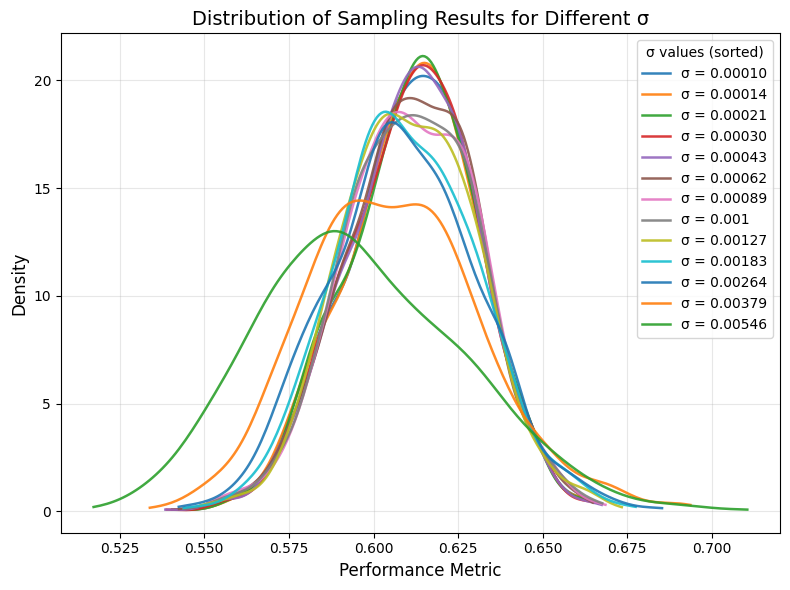

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# 假设已有：
# unet_sigma_list = ['0.1', '0.2', '0.05', ...]
# similarity_datas = [[1000个值], [1000个值], [1000个值], ...]

# === 1. 将 sigma 转为 float 并排序索引 ===
sigma_float = [float(s) for s in unet_sigma_list]
sorted_indices = np.argsort(sigma_float)

# === 2. 重新排序两个列表 ===
unet_sigma_list_sorted = [unet_sigma_list[i] for i in sorted_indices]
similarity_datas_sorted = [similarity_datas[i] for i in sorted_indices]

# === 3. 绘图 ===
plt.figure(figsize=(8, 6))

for sigma, samples in zip(unet_sigma_list_sorted, similarity_datas_sorted):
    data = np.array(samples)

    # 用核密度估计平滑分布
    kde = gaussian_kde(data)
    x_grid = np.linspace(data.min(), data.max(), 200)
    y_kde = kde(x_grid)

    plt.plot(x_grid, y_kde, label=f"σ = {sigma}", linewidth=1.8, alpha=0.9)

# === 4. 画图样式 ===
plt.xlabel("Performance Metric", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Sampling Results for Different σ", fontsize=14)
plt.legend(title="σ values (sorted)", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

id7

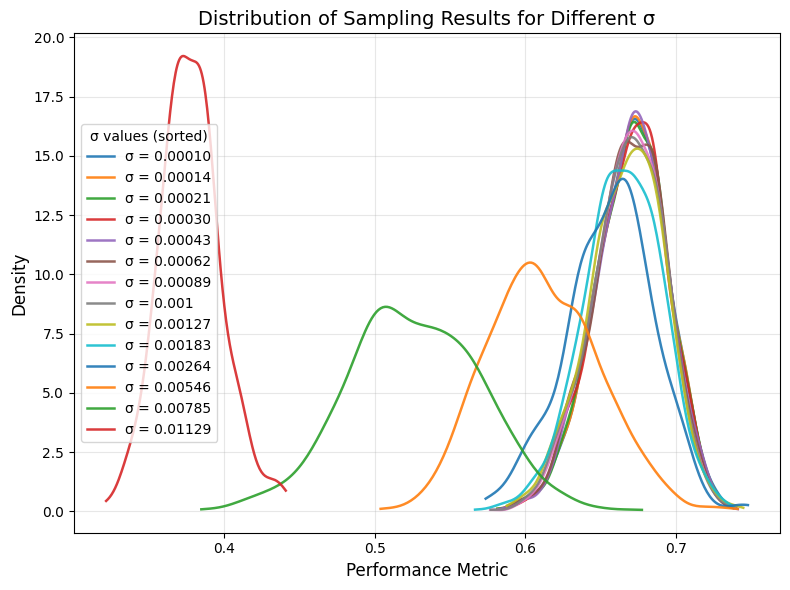

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# 假设已有：
# unet_sigma_list = ['0.1', '0.2', '0.05', ...]
# similarity_datas = [[1000个值], [1000个值], [1000个值], ...]

# === 1. 将 sigma 转为 float 并排序索引 ===
sigma_float = [float(s) for s in unet_sigma_list]
sorted_indices = np.argsort(sigma_float)

# === 2. 重新排序两个列表 ===
unet_sigma_list_sorted = [unet_sigma_list[i] for i in sorted_indices]
similarity_datas_sorted = [similarity_datas[i] for i in sorted_indices]

# === 3. 绘图 ===
plt.figure(figsize=(8, 6))

for sigma, samples in zip(unet_sigma_list_sorted, similarity_datas_sorted):
    data = np.array(samples)

    # 用核密度估计平滑分布
    kde = gaussian_kde(data)
    x_grid = np.linspace(data.min(), data.max(), 200)
    y_kde = kde(x_grid)

    plt.plot(x_grid, y_kde, label=f"σ = {sigma}", linewidth=1.8, alpha=0.9)

# === 4. 画图样式 ===
plt.xlabel("Performance Metric", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Sampling Results for Different σ", fontsize=14)
plt.legend(title="σ values (sorted)", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()